In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC

2024-03-01 07:20:40.217580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 07:20:40.217691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 07:20:40.392070: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir='/kaggle/input/auto-pcos/train'
batch_size = 32
img_height = 180
img_width = 180

In [3]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 3200 files belonging to 2 classes.
Using 2560 files for training.
Using 640 files for validation.


In [4]:
from matplotlib import pyplot as plt

In [5]:
batch = train_ds.as_numpy_iterator().next()

In [6]:
img, labels = batch

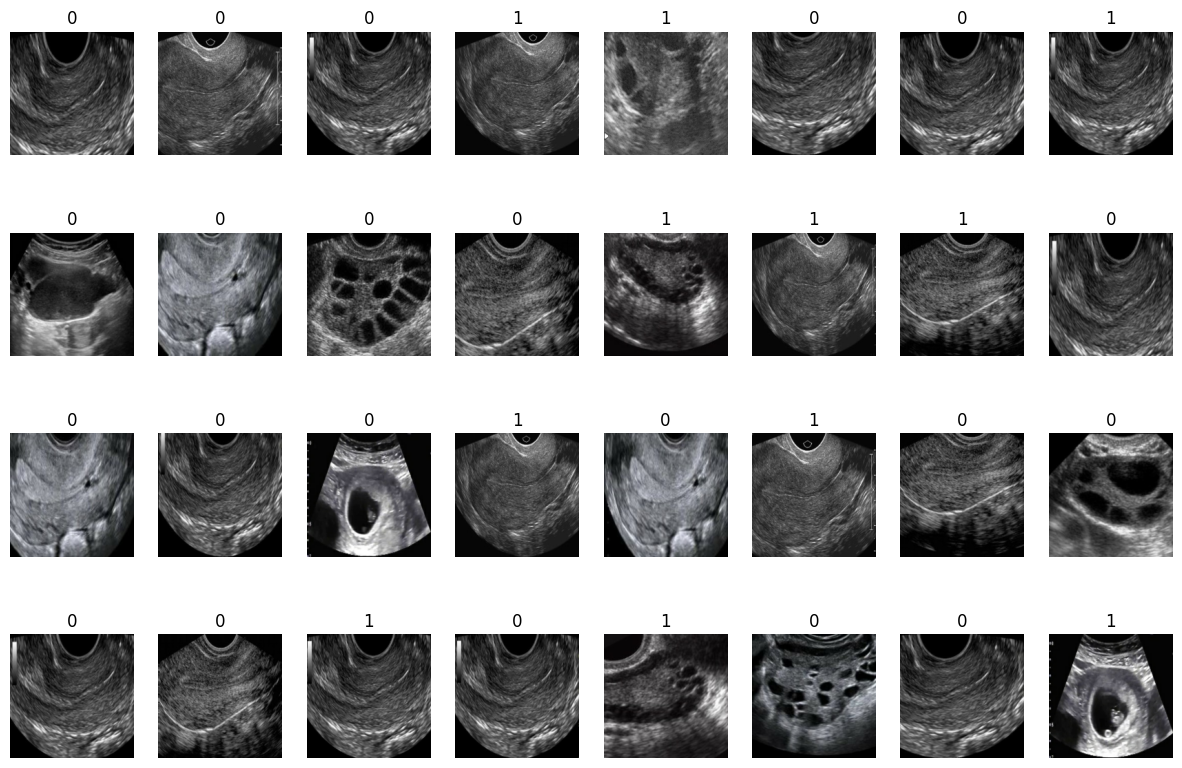

In [7]:
plt.figure(figsize=(15,10))
i = 1
for image, label in zip(img,labels):
    plt.subplot(4,8,i)
    plt.imshow(image/255.)
    plt.axis('off')
    plt.title(label)
    i += 1

In [8]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [9]:
num_classes = 2

with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((None,None, 3)),
        tf.keras.layers.Reshape((180,180,3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(256, 8, activation='relu'),  # Additional convolutional layer
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 16, activation='relu'),  # Additional convolutional layer
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 32, activation='relu'),  # Additional convolutional layer
        tf.keras.layers.MaxPooling2D(),
#         tf.keras.layers.Conv2D(32, 128, activation='relu'),
#         tf.keras.layers.MaxPooling2D(),
#         tf.keras.layers.Conv2DTranspose(64,64, activation = 'relu'),
#         tf.keras.layers.MaxPooling2D(),
#         tf.keras.layers.Conv2DTranspose(128,32, activation = 'relu'),
#         tf.keras.layers.MaxPooling2D(),
#         tf.keras.layers.Conv2DTranspose(256,16, activation = 'relu'),
#         tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),  # Additional dense layer
        tf.keras.layers.Dense(128, activation='relu'),  
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(
          optimizer='adam',
          loss= tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 173, 173, 256)  │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 86, 86, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 128)    │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │     8,388,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,925,762 (64.57 MB)

 Trainable params: 16,925,762 (64.57 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 57s 302ms/step - accuracy: 1.3017 - loss: 4.2311 - val_accuracy: 0.7000 - val_loss: 0.5841
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 306ms/step - accuracy: 1.4308 - loss: 1.1807 - val_accuracy: 0.7000 - val_loss: 0.5949
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 307ms/step - accuracy: 1.4080 - loss: 1.2569 - val_accuracy: 0.6969 - val_loss: 0.5534
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 295ms/step - accuracy: 1.4329 - loss: 1.0377 - val_accuracy: 0.7000 - val_loss: 0.5398
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 302ms/step - accuracy: 1.4496 - loss: 1.0071 - val_accuracy: 0.7469 - val_loss: 0.5102
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 307ms/step - accuracy: 1.4818 - loss: 1.0078 - val_accuracy: 0.7563 - val_loss: 0.4885
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 307ms/step - accuracy: 1.4961 - loss: 0.9665 - val_accuracy: 0.7375 - val_loss: 0.5003
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 302ms/step - accuracy: 1.5126 - loss: 0.9258 - val_accu

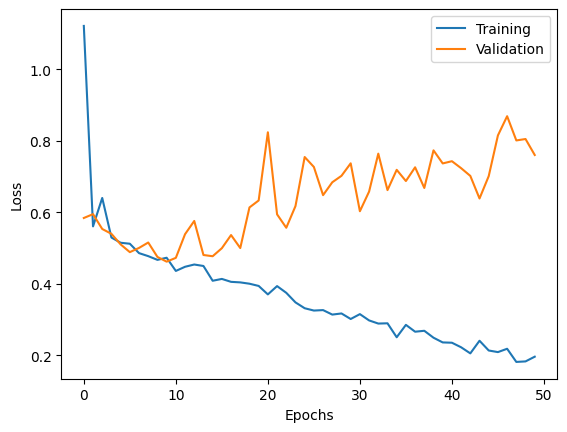

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training','Validation'])
plt.show()

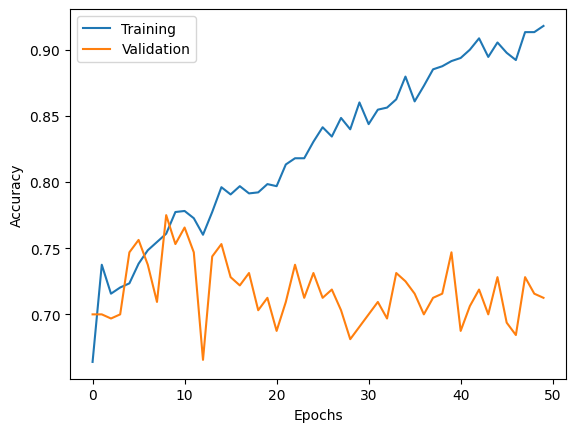

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training','Validation'])
plt.show()

In [14]:
# Assuming you have a training dataset called train_ds
training_accuracy = model.evaluate(train_ds)[1]
print("Training Accuracy:", training_accuracy)

80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 1.8186 - loss: 0.3736
Training Accuracy: 0.9164062738418579


In [15]:
# Assuming you have a training dataset called train_ds
training_accuracy = model.evaluate(val_ds)[1]
print("Training Accuracy:", training_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 1.3911 - loss: 1.6662
Training Accuracy: 0.7124999761581421


In [16]:
model.save('/kaggle/working.h5')
import pickle

In [17]:
import joblib

In [18]:
# Save RL_Model to file in the current working directory

joblib_file = "joblib_CNN_Model.pkl"  
joblib.dump(model, joblib_file)

TypeError: 'NoneType' object is not iterable

In [ ]:
import os

In [ ]:
preds = model.predict(val_ds)

In [ ]:
plt.figure(figsize=(15,10))
i = 1
for image, label in zip(list(test_ds.as_numpy_iterator())[:32],labels[:32]):
    plt.subplot(4,8,i)
    plt.imshow(image[0]/255.)
    plt.axis('off')
    plt.title(label)
    i += 1

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a trained model and a dataset
model = ...  # Your trained model goes here
X = ...  # Your dataset goes here

# Create a SHAP explainer
explainer = shap.Explainer(model, X)

# Calculate SHAP values
shap_values = explainer(X)

# Visualize the SHAP values for a specific instance
shap.summary_plot(shap_values, X, plot_type="bar")
plt.show()